In [ ]:
import numpy as np
import pandas as pd, re, requests
from itertools import combinations
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.auto import tqdm
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib.colors import ListedColormap
from matplotlib import cm


In [ ]:
df = pd.read_csv('diagnoses_icd10.csv')

# co_df = pd.read_csv("matrix/cat_co_matrix_counts.csv") # сколько уникальных пациентов имели одновременно диагнозы i и j
# fraction_df = pd.read_csv("matrix/cat_co_matrix_fraction.csv") # доля пациентов из всей выборки у которых одновременно были диагнозы i и j / всех пациентов
# cond_df= pd.read_csv("matrix/cat_co_matrix_conditional_prob.csv") # усл вероятность

Jaccard- like - идем в скрипт `get_jac_matrix.py`, там считается как: N_ij / (N_i + N_j - N_ij) для каждой пары категорий ij

In [ ]:
# Jaccard Similarity - посчитать насколько похожи диагнозы по набору пациентов, у которых они встречаются

# df_unique = df[['subject_id', 'icd10_category']].drop_duplicates()
# pivot = df_unique.groupby('subject_id')['icd10_category'].apply(set)

# mlb = MultiLabelBinarizer()
# binary_matrix = mlb.fit_transform(pivot)

# from sklearn.metrics import pairwise_distances
# jaccard_matrix = 1 - pairwise_distances(binary_matrix.T, metric='jaccard')

# jaccard_df = pd.DataFrame(jaccard_matrix, index=mlb.classes_, columns=mlb.classes_)
# jaccard_df.head()

In [ ]:
df_unique = df[['subject_id', 'icd10_category']].drop_duplicates()
pivot = df_unique.groupby('subject_id')['icd10_category'].apply(set)
df['icd10_category'].nunique()

1757

In [ ]:
# mlb = MultiLabelBinarizer()
# binary_matrix = mlb.fit_transform(pivot)
# binary_dense = binary_matrix.astype(bool).T  # T: диагнозы как строки

# n = binary_dense.shape[0]
# jaccard_result = np.zeros((n, n))

# for i in tqdm(range(n)):
#     for j in range(i, n):
#         score = jaccard_score(binary_dense[i], binary_dense[j])
#         jaccard_result[i, j] = score
#         jaccard_result[j, i] = score  # симметрично

# jaccard_df = pd.DataFrame(jaccard_result, index=mlb.classes_, columns=mlb.classes_)
# jaccard_df.to_csv('stat/jaccard_g.csv')


 25%|██▌       | 444/1757 [9:49:08<21:24:26, 58.70s/it]   

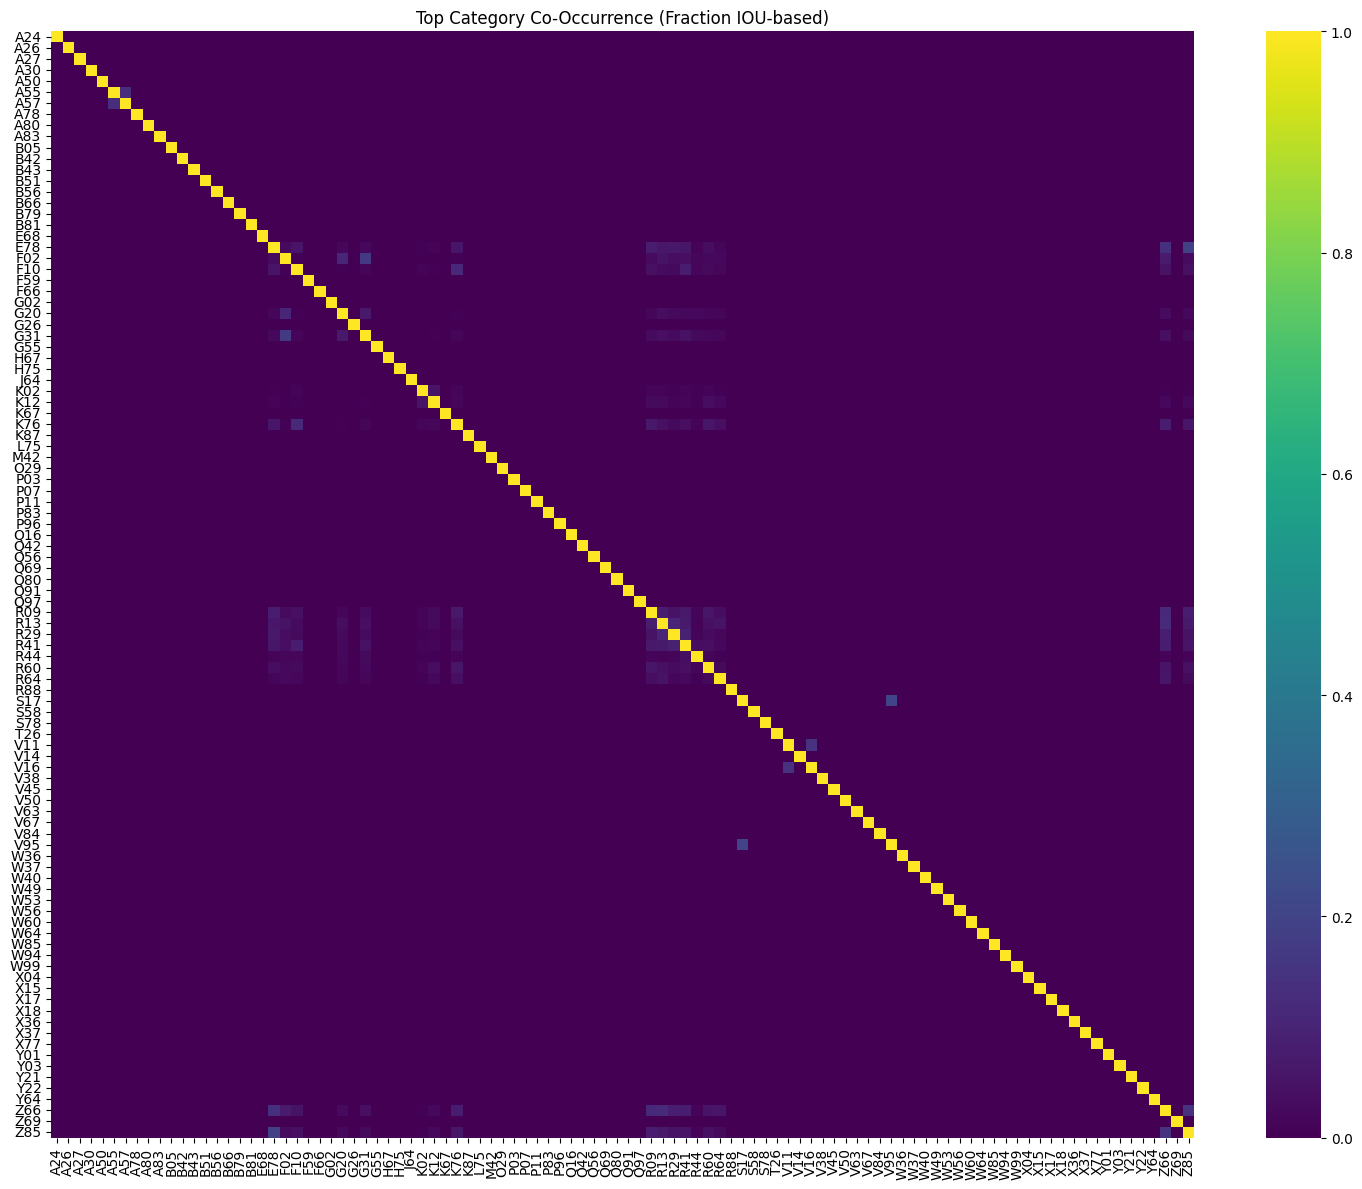

In [ ]:
fraction_jc = pd.read_csv(
    '/Users/sofsen/Desktop/SMILES 2025/Revealing-interconnections-between-diseases/statistic/matrix/new_cat_co_matrix_fraction.csv',
    index_col=0
)
N = 100  

diag_values = np.diag(fraction_jc.values)
top_indices = np.argsort(diag_values)[::-1][:N]
all_categories = fraction_jc.index.tolist()

top_cats = [all_categories[i] for i in top_indices]
top_cats_sorted = sorted(top_cats)

top_fraction_jc = fraction_jc.loc[top_cats_sorted, top_cats_sorted]

plt.figure(figsize=(15, 12))
sns.heatmap(top_fraction_jc, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Top Category Co-Occurrence (Fraction IOU-based)")
# plt.xticks(rotation=90, fontsize=8)
# plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

/var/folders/13/c45lzlsj5bs806n6mvnc_qd80000gn/T/ipykernel_926/1438832397.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_cmap = cm.get_cmap("viridis", 256)


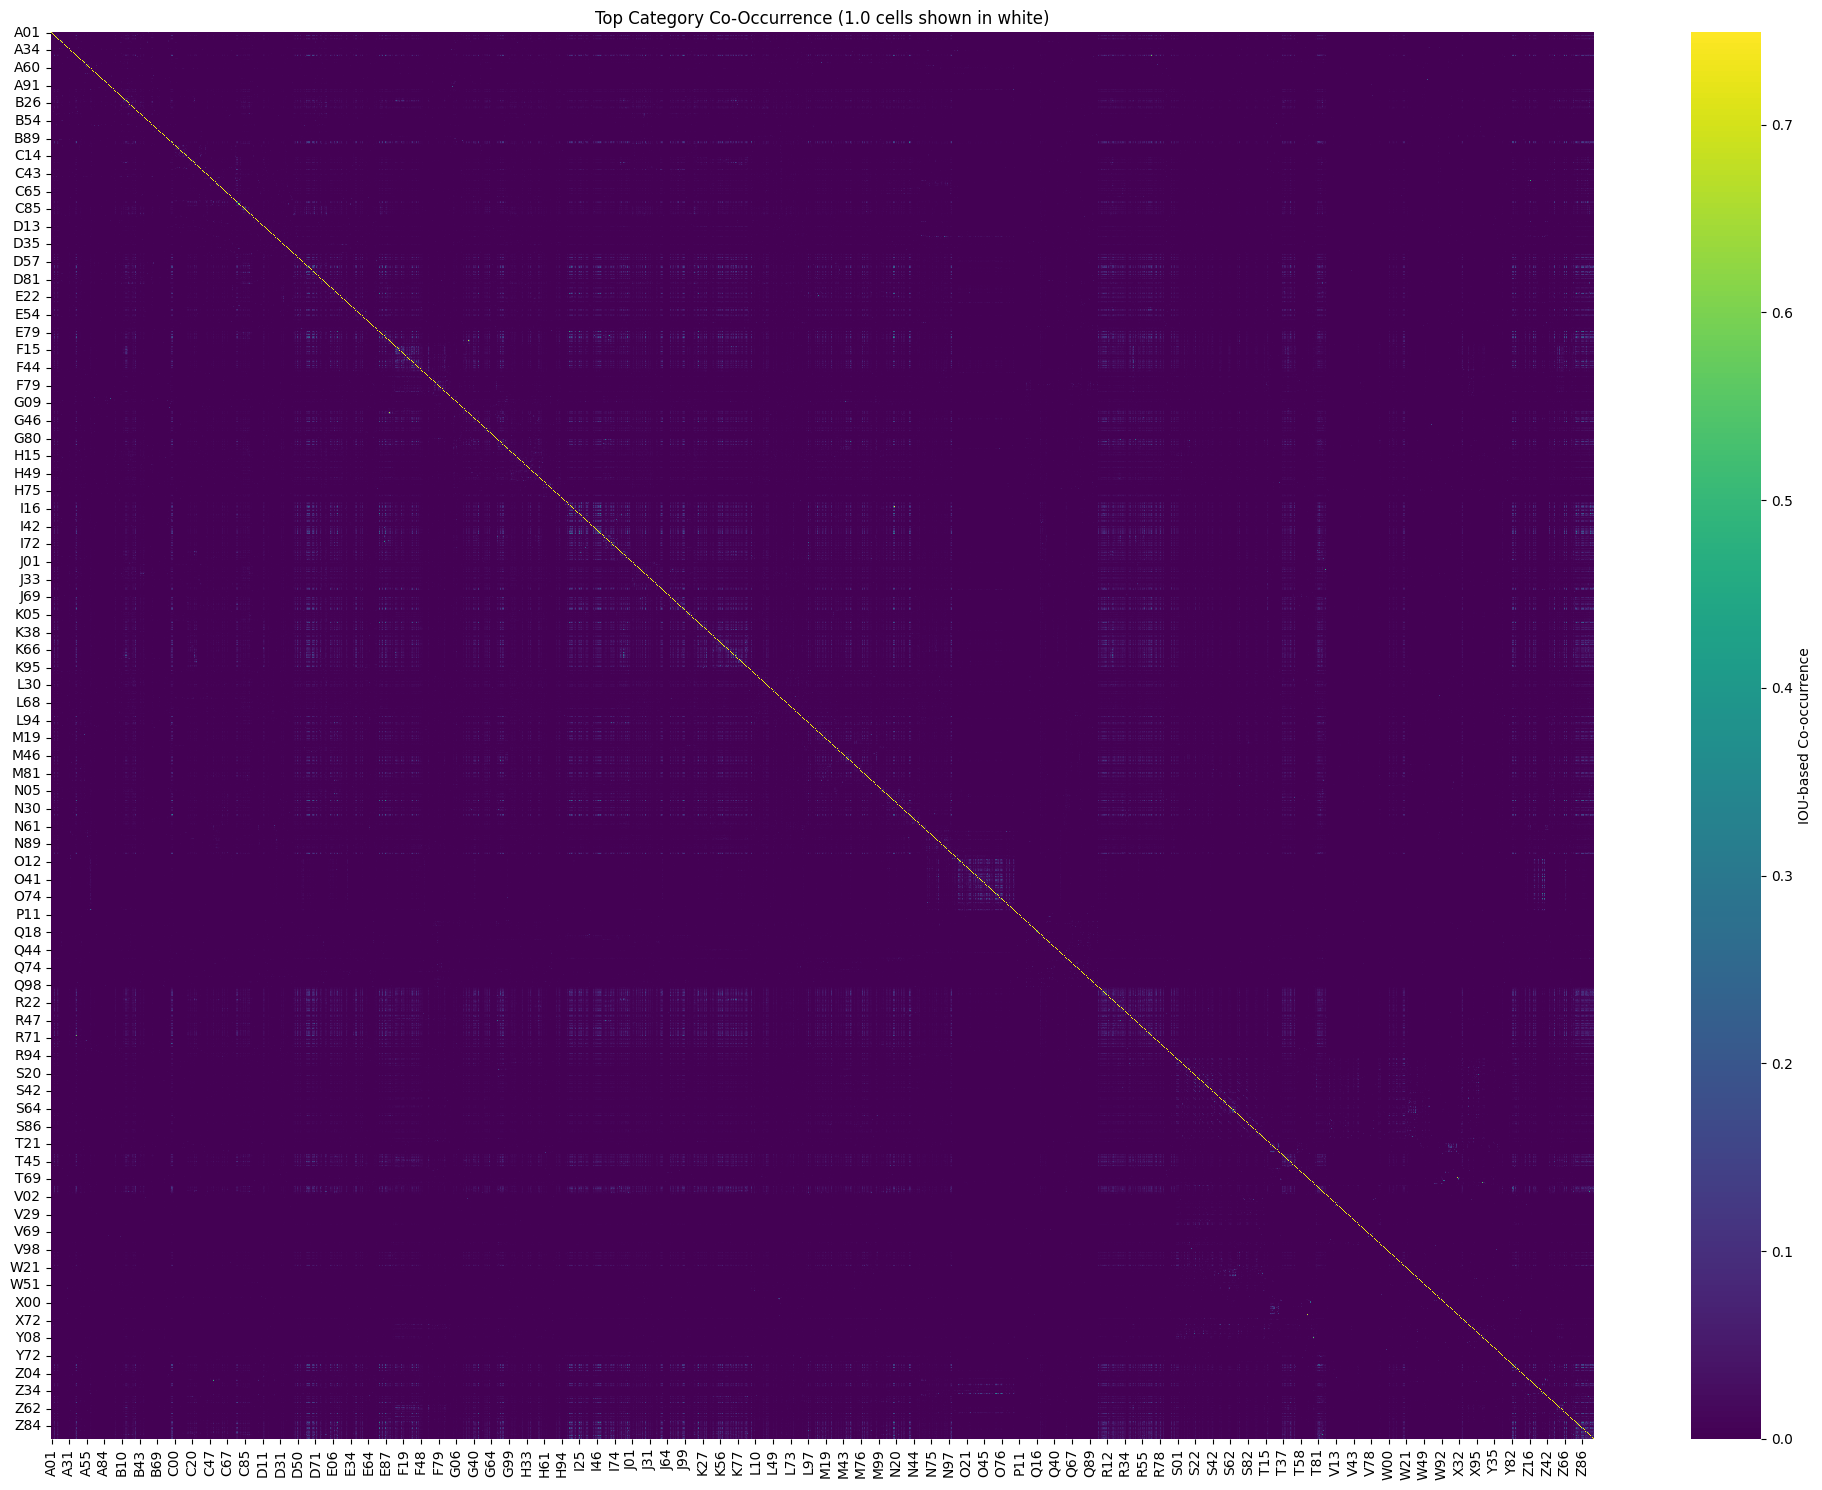

In [ ]:
# фикс цвета
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
N = 1754

#  пациенты только с одним диагнозом
diag_values = np.diag(fraction_jc.values)
top_indices = np.argsort(diag_values)[::-1][:N]

all_categories = fraction_jc.index.tolist()

top_cats = [all_categories[i] for i in top_indices]
# top_cats_sorted = sorted(top_cats)

# top_fraction_jc = fraction_jc.loc[top_cats_sorted, top_cats_sorted]
# top_fraction_jc = fraction_jc.loc[top_cats_sorted, top_cats_sorted]

data = top_fraction_jc.copy()
mask_ones = data == 1.0
data_masked = data.mask(mask_ones)

cmap = plt.cm.viridis.copy()
# cmap.set_bad(color='yellow')  

original_cmap = cm.get_cmap("viridis", 256)
truncated_cmap = ListedColormap(original_cmap(np.linspace(0, 1, 256)))
truncated_cmap.set_bad(color='lightyellow')

# Строим хитмап
plt.figure(figsize=(20, 15))
sns.heatmap(
    data_masked,
    cmap=truncated_cmap,
    # cmap=cmap,
    # xticklabels=True,
    # yticklabels=True,
    cbar_kws={"label": "IOU-based Co-occurrence"},
    # linewidths=0.1,
    # linecolor='gray'
)
plt.title("Top Category Co-Occurrence (1.0 cells shown in white)")
# plt.xticks(rotation=90, fontsize=8)
# plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# какие болезни предшествуют другим
df_sorted = df.sort_values(['subject_id', 'admittime'])

df_sorted['next_code'] = df_sorted.groupby('subject_id')['icd10_category'].shift(-1)
df_sorted['next_time'] = df_sorted.groupby('subject_id')['admittime'].shift(-1)

#  сколько раз диагноз i предшествовал диагнозу j
df_transitions = df_sorted.dropna(subset=['icd10_category', 'next_code'])
df_transitions = df_transitions[df_transitions['icd10_category'] != df_transitions['next_code']]

transition_counts = df_transitions.groupby(['icd10_category', 'next_code']).size().reset_index(name='count')
transition_counts.sort_values('count', ascending=False).head(10)
transition_counts.to_csv('stat/transition_counts.csv')

In [78]:
transition_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358957 entries, 0 to 358956
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   icd10_category  358957 non-null  object
 1   next_code       358957 non-null  object
 2   count           358957 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.2+ MB


In [77]:
transition_counts.sort_values('count', ascending = False).head()

,icd10_category,next_code,count
118224,I10,E78,46570
120286,I12,N18,27976
123879,I25,Z95,19550
324338,Y83,Y92,16847
61368,E66,Z68,15478


In [ ]:
transition_counts['fraction'] = 

In [ ]:
# # PMI какие коды сильно информативны друг о друге (например, редкие, но часто встречающиеся вместе) - Pointwise Mutual Information

# total_patients = df['subject_id'].nunique()
# co_occurrence = cond_df * co_df.values.diagonal()[:, None]  # восстанавливаем N_{i,j}

# P_i = co_df.values.diagonal() / total_patients
# P_j = co_df.values.diagonal() / total_patients
# P_ij = co_occurrence / total_patients

# with np.errstate(divide='ignore'):
#     pmi = np.log2(P_ij / (P_i[:, None] * P_j[None, :]))

# pmi_df = pd.DataFrame(pmi, index=cond_df.index, columns=cond_df.columns)
# pmi_df.to_csv('stat/pmi_df_g.csv')
